#Imports and Configuration

In [ ]:


import os
import time
import zipfile
from io import BytesIO
from collections import defaultdict
from PIL import Image

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from timm import create_model



ZIP_FAKE = "/content/zip_fake_cifake_images.zip"
ZIP_REAL = "/content/zip_real_cifake_images.zip"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGE_SIZE = 320
BATCH_SIZE = 12
EPOCHS = 30
PATIENCE = 8

LR_MAX = 5e-5
WEIGHT_DECAY = 1e-4
DROPOUT = 0.3
LABEL_SMOOTHING = 0.1

LABEL_MAP = {"fake": 0, "real": 1}
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


#Dataset Class

In [ ]:

class ZipImageDataset(Dataset):
    def __init__(self, zip_paths, transforms=None):
        self.items = []
        self._zip_cache = {}
        self.transforms = transforms

        for zip_path, label_str in zip_paths:
            with zipfile.ZipFile(zip_path) as z:
                for name in z.namelist():
                    if not name.lower().endswith((".png", ".jpg", ".jpeg")):
                        continue
                    self.items.append((zip_path, name, LABEL_MAP[label_str]))

        counts = defaultdict(int)
        for _, _, lbl in self.items:
            counts[lbl] += 1
        print(f"Dataset loaded: {len(self.items)} images | Class distribution: {dict(counts)}")

    def _open_zip(self, path):
        if path not in self._zip_cache:
            self._zip_cache[path] = zipfile.ZipFile(path)
        return self._zip_cache[path]

    def __getitem__(self, idx):
        zip_path, name, label = self.items[idx]
        z = self._open_zip(zip_path)
        img = Image.open(BytesIO(z.read(name))).convert("RGB")
        img = self.transforms(img) if self.transforms else T.ToTensor()(img)
        return img, torch.tensor(label)

    def __len__(self):
        return len(self.items)


#Model Builder

In [ ]:

def build_convnext_base(num_classes=2, dropout=DROPOUT):
    model = create_model(
        "convnext_base",
        pretrained=True,
        num_classes=num_classes,
        drop_rate=dropout
    )
    return model


#Validation with TTA

In [ ]:

def validate_tta(model, loader):
    model.eval()
    preds, labs = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = []
            for f in [None, [3], [2], [2, 3]]:
                xa = torch.flip(x, f) if f else x
                outputs.append(torch.softmax(model(xa), dim=1))
            out = torch.mean(torch.stack(outputs), dim=0)
            preds += out.argmax(1).cpu().tolist()
            labs += y.cpu().tolist()

    preds, labs = np.array(preds), np.array(labs)
    acc = (preds == labs).mean() * 100
    p = precision_score(labs, preds, zero_division=0)
    r = recall_score(labs, preds, zero_division=0)
    f = f1_score(labs, preds, zero_division=0)
    return acc, p, r, f


#Training Function

In [ ]:

def train_model(model, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
    optimizer = optim.AdamW(model.parameters(), lr=LR_MAX, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=1e-7
    )

    best_acc = 0
    wait = 0
    scaler = torch.cuda.amp.GradScaler()

    for ep in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                out = model(imgs)
                loss = criterion(out, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            running_loss += loss.item() * imgs.size(0)

        avg_loss = running_loss / len(train_loader.dataset)
        acc, p, r, f = validate_tta(model, val_loader)

        print(f"Epoch {ep:02d}/{EPOCHS} | Loss={avg_loss:.4f} | "
              f"Val Acc={acc:.2f}% | F1={f:.3f} | Precision={p:.3f} | Recall={r:.3f}")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_convnext_optimized.pth")
            wait = 0
        else:
            wait += 1
            if wait >= PATIENCE:
                print(f"Early stopping after {PATIENCE} epochs without improvement.")
                break

    print(f"Training complete. Best validation accuracy: {best_acc:.2f}%")
    return best_acc


#Fine-tuning Function

In [ ]:

def finetune_convnext_optimized():
    train_tf = T.Compose([
        T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        T.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.3),
        T.RandomRotation(degrees=15),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        T.RandomGrayscale(p=0.1),
        T.RandomApply([T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.3),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        T.RandomErasing(p=0.2, scale=(0.02, 0.15), ratio=(0.3, 3.3))
    ])

    val_tf = T.Compose([
        T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = ZipImageDataset([(ZIP_FAKE, "fake"), (ZIP_REAL, "real")])
    n = len(dataset)
    val_size = int(0.15 * n)
    train_ds, val_ds = random_split(dataset, [n - val_size, val_size],
                                    generator=torch.Generator().manual_seed(SEED))
    train_ds.dataset.transforms = train_tf
    val_ds.dataset.transforms = val_tf

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=2, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE * 2, shuffle=False,
                            num_workers=2, pin_memory=True, persistent_workers=True)

    model = build_convnext_base().to(DEVICE)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Model: ConvNeXt-Base | Total Params: {total_params:,} | Trainable: {trainable_params:,}")
    print(f"Device: {DEVICE} | Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
    print(f"Config: LR={LR_MAX}, Dropout={DROPOUT}, Label Smoothing={LABEL_SMOOTHING}")
    print(f"Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, Patience: {PATIENCE}\n")

    best_acc = train_model(model, train_loader, val_loader)

    print("\nFinal Evaluation (Best Model + TTA)")
    model.load_state_dict(torch.load("best_convnext_optimized.pth", map_location=DEVICE))
    acc, p, r, f = validate_tta(model, val_loader)

    print(f"Accuracy:  {acc:.2f}%")
    print(f"F1 Score:  {f:.3f}")
    print(f"Precision: {p:.3f}")
    print(f"Recall:    {r:.3f}")

    return {"final_acc": acc, "final_f1": f, "final_p": p, "final_r": r}


#ENTRY POINT

In [ ]:

if __name__ == "__main__":
    start = time.time()
    print("ConvNeXt-Base Fine-tuning for Deepfake Detection\n")

    results = finetune_convnext_optimized()
    elapsed = (time.time() - start) / 60.0

    print(f"\nTotal training time: {elapsed:.1f} minutes")
    print(f"Best model saved as: best_convnext_optimized.pth")

    if results["final_acc"] >= 97.0:
        print("Target achieved: ≥97% accuracy.")
    else:
        print(f"Final accuracy: {results['final_acc']:.2f}% (Target: 97%+)")


ConvNeXt-Base Fine-tuning for Deepfake Detection

Dataset loaded: 2000 images | Class distribution: {0: 1000, 1: 1000}
Model: ConvNeXt-Base | Total Params: 87,568,514 | Trainable: 87,568,514
Device: cuda | Image size: 320x320
Config: LR=5e-05, Dropout=0.3, Label Smoothing=0.1
Epochs: 30, Batch Size: 12, Patience: 8



/tmp/ipython-input-1239428173.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 01/30 | Loss=0.4520 | Val Acc=90.00% | F1=0.893 | Precision=0.926 | Recall=0.862


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 02/30 | Loss=0.2856 | Val Acc=92.67% | F1=0.924 | Precision=0.930 | Recall=0.917


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 03/30 | Loss=0.2387 | Val Acc=93.67% | F1=0.932 | Precision=0.970 | Recall=0.897


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 04/30 | Loss=0.2181 | Val Acc=94.67% | F1=0.944 | Precision=0.951 | Recall=0.938


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 05/30 | Loss=0.2109 | Val Acc=94.00% | F1=0.936 | Precision=0.964 | Recall=0.910


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 06/30 | Loss=0.2070 | Val Acc=95.00% | F1=0.948 | Precision=0.951 | Recall=0.945


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 07/30 | Loss=0.2039 | Val Acc=94.67% | F1=0.944 | Precision=0.964 | Recall=0.924


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 08/30 | Loss=0.2023 | Val Acc=95.33% | F1=0.952 | Precision=0.952 | Recall=0.952


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 09/30 | Loss=0.2020 | Val Acc=94.33% | F1=0.940 | Precision=0.957 | Recall=0.924


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10/30 | Loss=0.2156 | Val Acc=88.00% | F1=0.862 | Precision=0.974 | Recall=0.772


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11/30 | Loss=0.2450 | Val Acc=93.33% | F1=0.933 | Precision=0.908 | Recall=0.959


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12/30 | Loss=0.2173 | Val Acc=95.00% | F1=0.949 | Precision=0.928 | Recall=0.972


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13/30 | Loss=0.2052 | Val Acc=94.33% | F1=0.940 | Precision=0.964 | Recall=0.917


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 14/30 | Loss=0.2016 | Val Acc=95.33% | F1=0.953 | Precision=0.934 | Recall=0.972


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 15/30 | Loss=0.2004 | Val Acc=96.67% | F1=0.965 | Precision=0.972 | Recall=0.959


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 16/30 | Loss=0.2000 | Val Acc=97.00% | F1=0.969 | Precision=0.972 | Recall=0.966


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 17/30 | Loss=0.1999 | Val Acc=95.67% | F1=0.954 | Precision=0.971 | Recall=0.938


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 18/30 | Loss=0.1998 | Val Acc=96.00% | F1=0.958 | Precision=0.972 | Recall=0.945


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 19/30 | Loss=0.1997 | Val Acc=95.33% | F1=0.951 | Precision=0.971 | Recall=0.931


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 20/30 | Loss=0.1995 | Val Acc=96.00% | F1=0.958 | Precision=0.972 | Recall=0.945


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 21/30 | Loss=0.1994 | Val Acc=95.33% | F1=0.950 | Precision=0.978 | Recall=0.924


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 22/30 | Loss=0.1992 | Val Acc=96.00% | F1=0.958 | Precision=0.972 | Recall=0.945


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 23/30 | Loss=0.1992 | Val Acc=96.00% | F1=0.958 | Precision=0.972 | Recall=0.945


/tmp/ipython-input-1239428173.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 24/30 | Loss=0.1991 | Val Acc=96.00% | F1=0.958 | Precision=0.972 | Recall=0.945
Early stopping after 8 epochs without improvement.
Training complete. Best validation accuracy: 97.00%

Final Evaluation (Best Model + TTA)
Accuracy:  97.00%
F1 Score:  0.969
Precision: 0.972
Recall:    0.966

Total training time: 27.1 minutes
Best model saved as: best_convnext_optimized.pth
Target achieved: ≥97% accuracy.


In [ ]:
# ==========================================================
# Grad-CAM and Grad-CAM++ visualization for ConvNeXt-Base
# ==========================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# ---------------- Utility: find last conv layer ----------------
def get_last_conv_layer(model):
    for name, module in reversed(model.named_modules()):
        if isinstance(module, torch.nn.Conv2d):
            return module
    raise ValueError("No Conv2d layer found in model!")

# ---------------- Core Grad-CAM class ----------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, inp, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(
            self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(
            self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for h in self.hook_handles:
            h.remove()

    def generate(self, input_tensor, class_idx=None, use_gradcam_plus=False):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        target = output[0, class_idx]
        target.backward(retain_graph=True)

        grads = self.gradients[0]      # (C,H,W)
        acts  = self.activations[0]    # (C,H,W)

        if not use_gradcam_plus:
            # -------- Grad-CAM weights --------
            weights = grads.mean(dim=(1,2))
            cam = torch.sum(weights[:, None, None] * acts, dim=0)
        else:
            # -------- Grad-CAM++ weights --------
            grads_power_2 = grads ** 2
            grads_power_3 = grads ** 3
            denom = 2 * grads_power_2 + torch.sum(acts * grads_power_3, dim=(1,2), keepdim=True)
            denom = torch.where(denom != 0.0, denom, torch.ones_like(denom))
            alpha = grads_power_2 / denom
            weights = torch.sum(alpha * torch.relu(grads), dim=(1,2))
            cam = torch.sum(weights[:, None, None] * acts, dim=0)

        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)
        return cam.cpu().numpy(), class_idx

# ---------------- Visualization helper ----------------
def show_cam_on_image(img_path, model, transform, use_gradcam_plus=False):
    model.eval()
    target_layer = get_last_conv_layer(model)
    gradcam = GradCAM(model, target_layer)

    pil_img = Image.open(img_path).convert("RGB")
    input_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    cam, pred_class = gradcam.generate(input_tensor, use_gradcam_plus=use_gradcam_plus)
    gradcam.remove_hooks()

    img_np = np.array(pil_img.resize((cam.shape[1], cam.shape[0]))) / 255.0
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255.0
    overlay = np.clip(heatmap * 0.5 + img_np * 0.5, 0, 1)

    title = "Grad-CAM++" if use_gradcam_plus else "Grad-CAM"
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heatmap[..., ::-1]); plt.title(title + " Heatmap"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay[..., ::-1]); plt.title(title + " Overlay"); plt.axis("off")
    plt.tight_layout(); plt.show()

# ---------------- Example usage ----------------
# model.load_state_dict(torch.load("best_convnext_optimized.pth", map_location=DEVICE))
# test_image = "/content/sample_test_image.jpg"
# show_cam_on_image(test_image, model, val_tf, use_gradcam_plus=False)  # Grad-CAM
# show_cam_on_image(test_image, model, val_tf, use_gradcam_plus=True)   # Grad-CAM++


In [ ]:
# Load your trained ConvNeXt model
from timm import create_model

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_model("convnext_base", pretrained=False, num_classes=2, drop_rate=0.3)
state_dict = torch.load("best_convnext_optimized.pth", map_location=DEVICE)
model.load_state_dict(state_dict)
model.to(DEVICE)
model.eval()


ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [ ]:
import torch
import torchvision.transforms as T

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image size (must match the one used during training)
IMAGE_SIZE = 320

# Validation transform (same normalization as training)
val_tf = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


Total checked: 400 | Correct: 399
Correct Sample: True=fake | Pred=fake | Image=fake_cifake_images/83.png


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


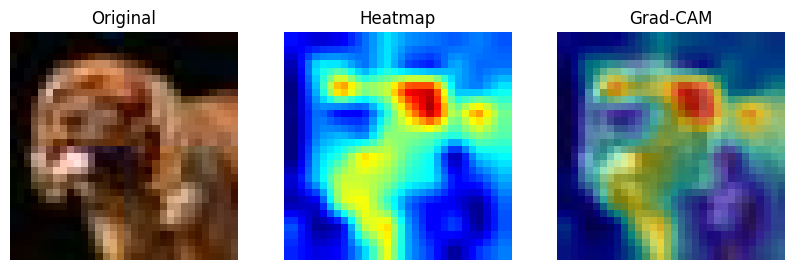

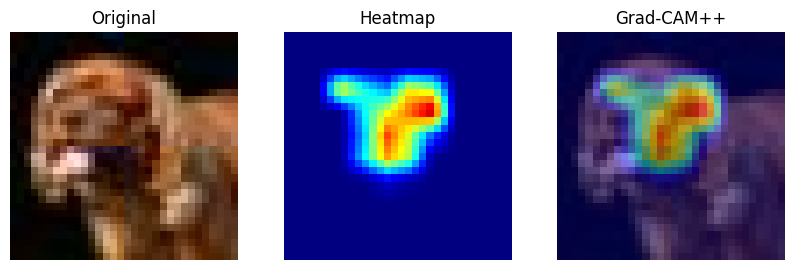

Correct Sample: True=fake | Pred=fake | Image=fake_cifake_images/295.png


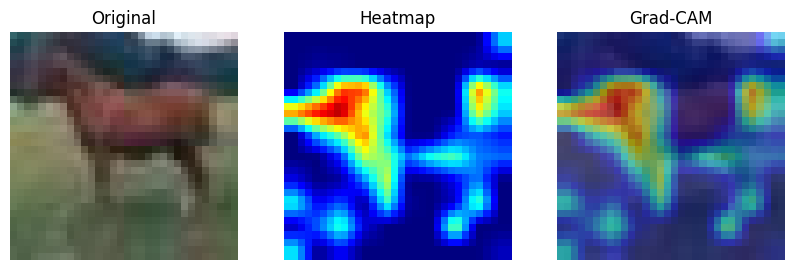

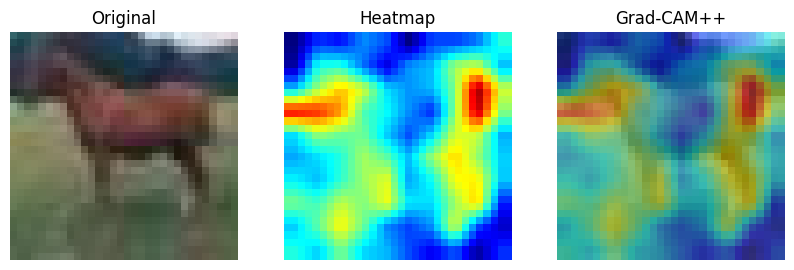

Correct Sample: True=fake | Pred=fake | Image=fake_cifake_images/535.png


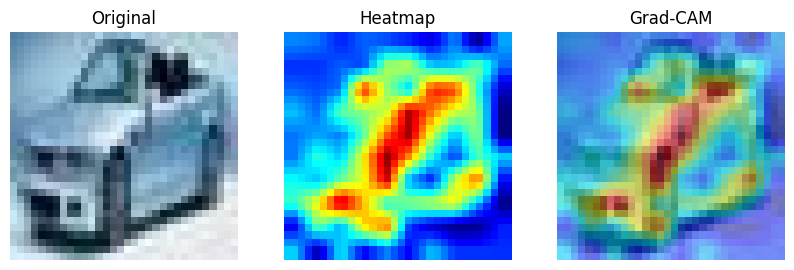

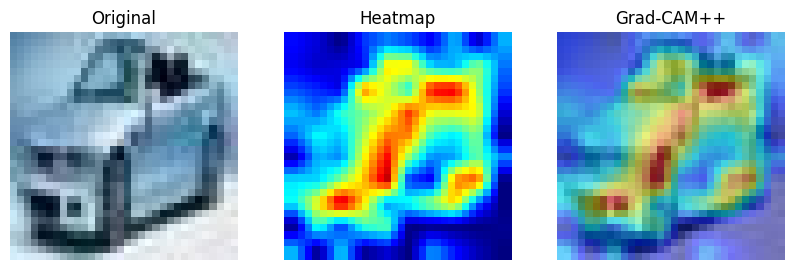

Correct Sample: True=fake | Pred=fake | Image=fake_cifake_images/168.png


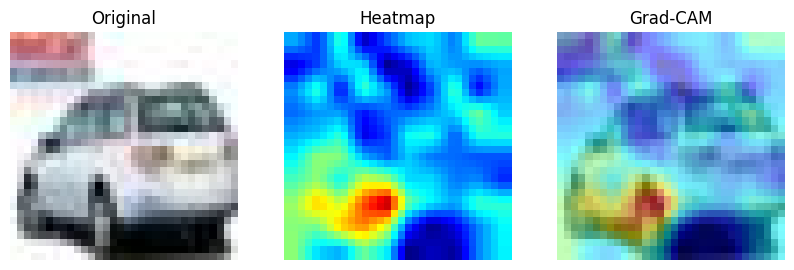

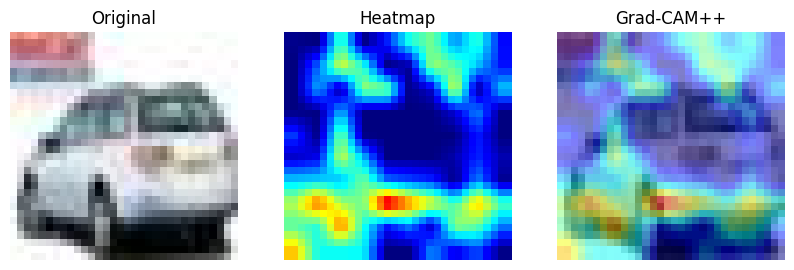

Correct Sample: True=fake | Pred=fake | Image=fake_cifake_images/266.png


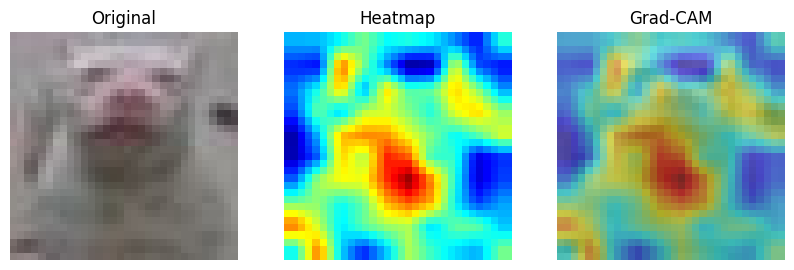

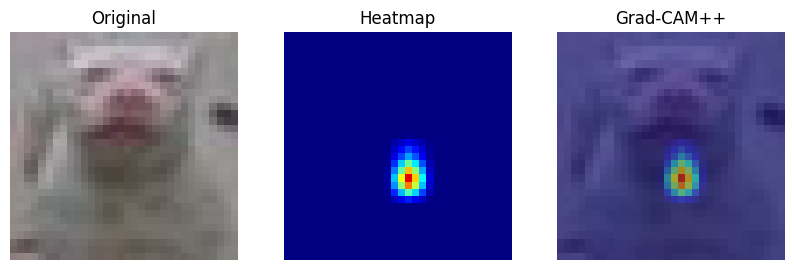

In [ ]:
# -----------------------------------------------
# GENERATE GRAD-CAM AND GRAD-CAM++ FOR CORRECTLY CLASSIFIED IMAGES ONLY
# -----------------------------------------------

import io, random, zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from timm import create_model
from PIL import Image

# CONFIG
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 320
MODEL_PATH = "best_convnext_optimized.pth"
ZIP_FAKE = "/content/zip_fake_cifake_images.zip"
ZIP_REAL = "/content/zip_real_cifake_images.zip"
LABEL_MAP = {"fake": 0, "real": 1}
INV_LABEL = {0: "fake", 1: "real"}

# -----------------------------------------------
# Load Model
# -----------------------------------------------
model = create_model("convnext_base", pretrained=False, num_classes=2, drop_rate=0.3)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.to(DEVICE)
model.eval()

# -----------------------------------------------
# Transforms
# -----------------------------------------------
val_tf = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# -----------------------------------------------
# Find Last Conv Layer
# -----------------------------------------------
def get_last_conv_layer(model):
    modules = list(model.named_modules())
    for name, module in reversed(modules):
        if isinstance(module, torch.nn.Conv2d):
            return module
    raise ValueError("No Conv2d layer found!")

# -----------------------------------------------
# GradCAM Class
# -----------------------------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, inp, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None, use_gradcam_plus=False):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        target = output[0, class_idx]
        target.backward(retain_graph=True)

        grads = self.gradients[0]
        acts = self.activations[0]

        if not use_gradcam_plus:
            weights = grads.mean(dim=(1,2))
            cam = torch.sum(weights[:, None, None] * acts, dim=0)
        else:
            grads2 = grads ** 2
            grads3 = grads ** 3
            denom = 2 * grads2 + torch.sum(acts * grads3, dim=(1,2), keepdim=True)
            denom = torch.where(denom != 0.0, denom, torch.ones_like(denom))
            alpha = grads2 / denom
            weights = torch.sum(alpha * torch.relu(grads), dim=(1,2))
            cam = torch.sum(weights[:, None, None] * acts, dim=0)

        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam.cpu().numpy(), class_idx

# -----------------------------------------------
# Visualization
# -----------------------------------------------
def visualize_cam(img_pil, cam, title):
    img_np = np.array(img_pil) / 255.0
    cam_resized = cv2.resize(cam, (img_pil.width, img_pil.height))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = heatmap[..., ::-1] / 255.0
    overlay = np.clip(0.5 * img_np + 0.5 * heatmap, 0, 1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heatmap); plt.title("Heatmap"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title(title); plt.axis("off")
    plt.show()

# -----------------------------------------------
# Extract Samples
# -----------------------------------------------
def extract_validation_samples(model, zip_fake, zip_real, transform, num_samples=200):
    data = []
    for zip_path, label_str in [(zip_fake, "fake"), (zip_real, "real")]:
        with zipfile.ZipFile(zip_path) as z:
            names = [n for n in z.namelist() if n.lower().endswith((".jpg",".jpeg",".png"))]
            random.shuffle(names)
            for name in names[:num_samples]:
                img = Image.open(io.BytesIO(z.read(name))).convert("RGB")
                tensor = transform(img).unsqueeze(0).to(DEVICE)
                with torch.no_grad():
                    pred = model(tensor).argmax(1).item()
                data.append((img, label_str, INV_LABEL[pred], name))
    return data

# -----------------------------------------------
# Collect only correct classifications
# -----------------------------------------------
samples = extract_validation_samples(model, ZIP_FAKE, ZIP_REAL, val_tf, num_samples=200)
correct = [s for s in samples if s[1] == s[2]]

print(f"Total checked: {len(samples)} | Correct: {len(correct)}")

# Randomly select 5 correct samples
correct_subset = random.sample(correct, min(5, len(correct)))

# -----------------------------------------------
# Run Grad-CAM on correctly classified images
# -----------------------------------------------
target_layer = get_last_conv_layer(model)
gradcam = GradCAM(model, target_layer)

for img, true_lbl, pred_lbl, name in correct_subset:
    print(f"Correct Sample: True={true_lbl} | Pred={pred_lbl} | Image={name}")
    input_tensor = val_tf(img).unsqueeze(0).to(DEVICE)

    cam, _ = gradcam.generate(input_tensor, use_gradcam_plus=False)
    visualize_cam(img, cam, "Grad-CAM")

    cam_pp, _ = gradcam.generate(input_tensor, use_gradcam_plus=True)
    visualize_cam(img, cam_pp, "Grad-CAM++")


In [ ]:
class ScoreCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self._register_hook()

    def _register_hook(self):
        def forward_hook(module, inp, output):
            self.activations = output.detach()
        self.target_layer.register_forward_hook(forward_hook)

    def generate(self, input_tensor, class_idx=None):
        device = input_tensor.device

        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(1).item()

        acts = self.activations[0]  # shape: C, H, W
        C, H, W = acts.shape

        # Normalize activations
        acts_norm = (acts - acts.min()) / (acts.max() - acts.min() + 1e-8)

        weights = []

        # Compute score for each channel
        for i in range(C):
            act_map = acts_norm[i].unsqueeze(0).unsqueeze(0)
            act_map_up = torch.nn.functional.interpolate(
                act_map,
                size=input_tensor.shape[2:],
                mode="bilinear",
                align_corners=False
            )

            masked_input = input_tensor * act_map_up

            # Forward pass
            score = self.model(masked_input)[0, class_idx]

            # Move to cpu number
            weights.append(score.detach().item())

        # Convert weights to tensor ON SAME DEVICE as activations
        weights = torch.tensor(weights, device=device, dtype=acts.dtype)

        # Normalize weights
        weights = (weights - weights.min()) / (weights.max() - weights.min() + 1e-8)

        # Weighted sum
        cam = torch.sum(weights[:, None, None] * acts, dim=0)

        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam.cpu().numpy(), class_idx


In [ ]:
# -----------------------------------------------
# INTEGRATED GRADIENTS IMPLEMENTATION
# -----------------------------------------------

class IntegratedGradients:
    def __init__(self, model):
        self.model = model

    def generate(self, input_tensor, class_idx=None, steps=50):
        self.model.eval()

        if class_idx is None:
            output = self.model(input_tensor)
            class_idx = output.argmax(1).item()

        baseline = torch.zeros_like(input_tensor).to(input_tensor.device)

        scaled_inputs = [
            baseline + (float(i) / steps) * (input_tensor - baseline)
            for i in range(steps + 1)
        ]

        gradients = []
        for inp in scaled_inputs:
            inp = inp.requires_grad_()
            output = self.model(inp)
            target = output[0, class_idx]
            self.model.zero_grad()
            target.backward(retain_graph=True)
            gradients.append(inp.grad.detach().clone())

        grads = torch.stack(gradients, dim=0)
        avg_grad = grads[:-1].mean(dim=0)
        integrated_gradients = (input_tensor - baseline) * avg_grad

        ig = integrated_gradients.squeeze().cpu().numpy()
        ig = np.mean(np.abs(ig), axis=0)

        ig -= ig.min()
        ig /= (ig.max() + 1e-8)

        return ig, class_idx


In [ ]:
target_layer = get_last_conv_layer(model)

scorecam = ScoreCAM(model, target_layer)
ig = IntegratedGradients(model)


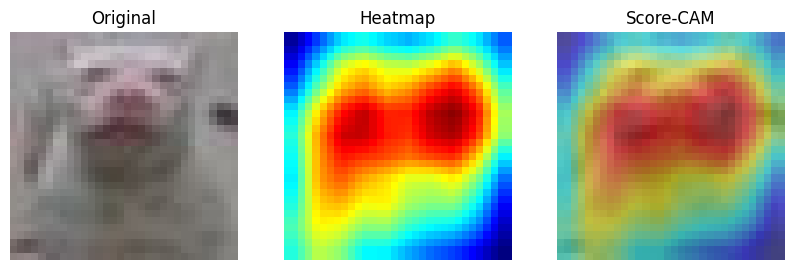

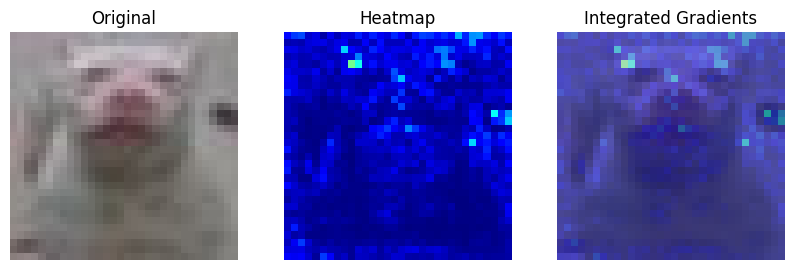

In [ ]:
# Score-CAM
score_map, idx = scorecam.generate(input_tensor)
visualize_cam(img, score_map, "Score-CAM")

# Integrated Gradients
ig_map, idx = ig.generate(input_tensor)
visualize_cam(img, ig_map, "Integrated Gradients")


In [ ]:
def visualize_xai_grid(img_pil, gradcam_map, gradcampp_map, scorecam_map, title_prefix="XAI"):
    import matplotlib.pyplot as plt
    import numpy as np
    import cv2

    img_np = np.array(img_pil) / 255.0

    def apply_heatmap(cam):
        cam_resized = cv2.resize(cam, (img_pil.width, img_pil.height))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = heatmap[..., ::-1] / 255.0
        overlay = np.clip(0.5 * img_np + 0.5 * heatmap, 0, 1)
        return heatmap, overlay

    heat_gc, ov_gc = apply_heatmap(gradcam_map)
    heat_gpp, ov_gpp = apply_heatmap(gradcampp_map)
    heat_sc, ov_sc = apply_heatmap(scorecam_map)

    plt.figure(figsize=(12, 8))

    # 1 Original
    plt.subplot(2, 2, 1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis("off")

    # 2 Grad-CAM
    plt.subplot(2, 2, 2)
    plt.imshow(ov_gc)
    plt.title("Grad-CAM")
    plt.axis("off")

    # 3 Grad-CAM++
    plt.subplot(2, 2, 3)
    plt.imshow(ov_gpp)
    plt.title("Grad-CAM++")
    plt.axis("off")

    # 4 Score-CAM
    plt.subplot(2, 2, 4)
    plt.imshow(ov_sc)
    plt.title("Score-CAM")
    plt.axis("off")

    plt.suptitle(title_prefix)
    plt.tight_layout()
    plt.show()


In [ ]:
import os
def save_xai_outputs(img_pil, gradcam_map, gradcampp_map, scorecam_map, ig_map, save_dir, base_name):
    import numpy as np
    import cv2

    os.makedirs(save_dir, exist_ok=True)

    img_np = np.array(img_pil)
    cv2.imwrite(os.path.join(save_dir, base_name + "_original.png"), cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))

    def save_cam(cam, suffix):
        cam_resized = cv2.resize(cam, (img_pil.width, img_pil.height))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        out_path = os.path.join(save_dir, base_name + "_" + suffix + ".png")
        cv2.imwrite(out_path, heatmap)

    save_cam(gradcam_map, "gradcam")
    save_cam(gradcampp_map, "gradcampp")
    save_cam(scorecam_map, "scorecam")
    save_cam(ig_map, "integrated_gradients")


In [ ]:
gc_map, _   = gradcam.generate(input_tensor)
gpp_map, _  = gradcam.generate(input_tensor, use_gradcam_plus=True)
sc_map, _   = scorecam.generate(input_tensor)
ig_map, _   = ig.generate(input_tensor)


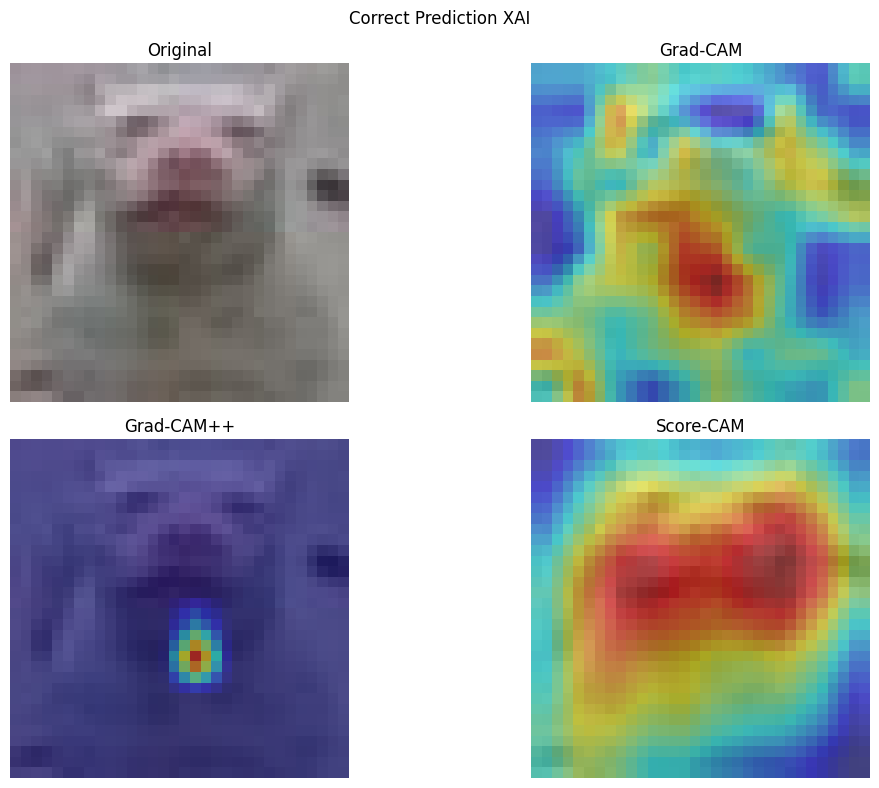

In [ ]:
visualize_xai_grid(img, gc_map, gpp_map, sc_map, "Correct Prediction XAI")


In [ ]:
save_xai_outputs(
    img,
    gc_map,
    gpp_map,
    sc_map,
    ig_map,
    save_dir="xai_outputs",
    base_name="image1"
)


In [ ]:
# -------------------------
# Batch Grad-CAM++ Consistency Test for Tiny Blobs
# -------------------------
import os
import csv
import numpy as np
import cv2
import torch
from tqdm import tqdm

# CONFIG
OUT_DIR = "xai_batch_results"
os.makedirs(OUT_DIR, exist_ok=True)
CSV_PATH = os.path.join(OUT_DIR, "gradcampp_summary.csv")

# Parameters you can tune
NUM_IMAGES = 100             # how many correct images to check (set <= len(correct))
THRESH_QUANTILE = 0.95       # threshold top X% of cam values to define hotspot
MIN_HOTSPOT_AREA_PX = 4      # ignore tiny 1-3 px islands (set to 0 to keep all)
REL_AREA_THRESHOLD = 0.001   # consider hotspot "tiny" if area < REL_AREA_THRESHOLD * image_area
SAVE_OVERLAYS = True         # save visualization overlays for manual check
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure gradcam uses gradcam_plus path (we'll call with use_gradcam_plus=True)
# target_layer = get_last_conv_layer(model)  # reuse your earlier function or set an appropriate layer
# gradcampp = GradCAM(model, target_layer)   # if you don't have one yet

def normalize_cam(cam):
    cam = np.maximum(cam, 0.0)
    if cam.max() > 0:
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
    else:
        cam = np.zeros_like(cam)
    return cam

def find_hotspots(cam, quantile=THRESH_QUANTILE, min_area_px=MIN_HOTSPOT_AREA_PX):
    """
    cam: 2D numpy normalized [0,1]
    returns: list of dicts {area_px, bbox, centroid}
    """
    thr = np.quantile(cam, quantile)
    mask = (cam >= thr).astype(np.uint8)  # binary mask
    # Optional morphological cleaning (remove tiny noise)
    # kernel = np.ones((3,3), np.uint8)
    # mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    hotspots = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area_px:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"]/M["m00"])
            cy = int(M["m01"]/M["m00"])
        else:
            cx, cy = x + w//2, y + h//2
        hotspots.append({"area_px": area, "bbox": (x,y,w,h), "centroid": (cx,cy)})
    return hotspots, mask

def overlay_cam_on_image(img_pil, cam, alpha=0.5):
    # returns overlay RGB as uint8
    img_np = np.array(img_pil).astype(np.float32) / 255.0
    cam_resized = cv2.resize(cam, (img_pil.width, img_pil.height))
    heat = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)  # BGR
    heat = heat[..., ::-1].astype(np.float32) / 255.0  # to RGB float
    overlay = np.clip((1-alpha) * img_np + alpha * heat, 0, 1)
    return (overlay * 255).astype(np.uint8), (heat * 255).astype(np.uint8)

# Prepare list of images to process
candidates = correct[:]   # use your previously computed 'correct' list
if len(candidates) == 0:
    raise RuntimeError("No correct samples found. Run the validation extraction first.")
N = min(NUM_IMAGES, len(candidates))
selected = random.sample(candidates, N)

# CSV header
with open(CSV_PATH, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "image_name", "true_label", "pred_label",
        "img_w", "img_h",
        "num_hotspots", "total_hotspot_area_px", "total_hotspot_rel_area",
        "largest_hotspot_area_px", "largest_hotspot_rel_area",
        "mean_hotspot_area_px", "mean_hotspot_rel_area",
        "hotspot_centroids"  # list of (x,y)
    ])

# Run batch
agg_num_hotspots = []
agg_largest_rel = []
for idx, (img_pil, true_lbl, pred_lbl, img_name) in enumerate(tqdm(selected, desc="GradCAM++ batch")):
    # Prepare input tensor (assume val_tf exists)
    input_tensor = val_tf(img_pil).unsqueeze(0).to(DEVICE)

    # Generate Grad-CAM++ map using your gradcam object/class
    cam_map, class_idx = gradcam.generate(input_tensor, use_gradcam_plus=True)
    cam_map = normalize_cam(cam_map)  # 2D numpy [0,1]
    h, w = cam_map.shape
    img_area = img_pil.width * img_pil.height

    # Find hotspots
    hotspots, mask = find_hotspots(cam_map, quantile=THRESH_QUANTILE, min_area_px=MIN_HOTSPOT_AREA_PX)
    num_hotspots = len(hotspots)
    areas = [h_["area_px"] for h_ in hotspots] if hotspots else [0.0]
    total_area = float(np.sum(areas)) if areas else 0.0
    largest_area = float(np.max(areas)) if areas else 0.0
    mean_area = float(np.mean(areas)) if hotspots else 0.0

    # relative areas wrt full image
    total_rel = total_area / img_area
    largest_rel = largest_area / img_area
    mean_rel = mean_area / img_area

    centroids = [h_["centroid"] for h_ in hotspots]

    # Save overlay and mask if desired
    base = os.path.splitext(os.path.basename(img_name))[0]
    base_name = f"{idx:03d}_{base}"

    if SAVE_OVERLAYS:
        overlay_rgb, heat_rgb = overlay_cam_on_image(img_pil, cam_map, alpha=0.5)
        save_ov_path = os.path.join(OUT_DIR, base_name + "_gradcampp_overlay.png")
        save_heat_path = os.path.join(OUT_DIR, base_name + "_gradcampp_heat.png")
        cv2.imwrite(save_ov_path, cv2.cvtColor(overlay_rgb, cv2.COLOR_RGB2BGR))
        cv2.imwrite(save_heat_path, cv2.cvtColor(heat_rgb, cv2.COLOR_RGB2BGR))
        # save binary mask visual
        mask_vis = (mask * 255).astype(np.uint8)
        mask_vis = cv2.resize(mask_vis, (img_pil.width, img_pil.height), interpolation=cv2.INTER_NEAREST)
        cv2.imwrite(os.path.join(OUT_DIR, base_name + "_mask.png"), mask_vis)

    # Write summary row
    with open(CSV_PATH, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            img_name, true_lbl, pred_lbl, img_pil.width, img_pil.height,
            num_hotspots, total_area, total_rel,
            largest_area, largest_rel,
            mean_area, mean_rel,
            ";".join([f"{c[0]}_{c[1]}" for c in centroids])
        ])

    agg_num_hotspots.append(num_hotspots)
    agg_largest_rel.append(largest_rel)

# Aggregate output
agg_num_hotspots = np.array(agg_num_hotspots)
agg_largest_rel = np.array(agg_largest_rel)

print("=== Grad-CAM++ Batch Summary ===")
print(f"Images processed: {N}")
print(f"Average number of hotspots per image: {agg_num_hotspots.mean():.3f} (median {np.median(agg_num_hotspots)})")
print(f"Fraction images with >=1 hotspot: {(agg_num_hotspots > 0).mean():.3f}")
print(f"Avg largest hotspot relative area: {agg_largest_rel.mean():.6f}")
print()
print(f"Results saved in: {OUT_DIR}")
print(f"Summary CSV: {CSV_PATH}")


GradCAM++ batch: 100%|██████████| 100/100 [00:12<00:00,  8.26it/s]

=== Grad-CAM++ Batch Summary ===
Images processed: 100
Average number of hotspots per image: 0.320 (median 0.0)
Fraction images with >=1 hotspot: 0.320
Avg largest hotspot relative area: 0.025313

Results saved in: xai_batch_results
Summary CSV: xai_batch_results/gradcampp_summary.csv


In [ ]:
import pandas as pd
pd.read_csv('xai_batch_results/gradcampp_summary.csv')

,image_name,true_label,pred_label,img_w,img_h,num_hotspots,total_hotspot_area_px,total_hotspot_rel_area,largest_hotspot_area_px,largest_hotspot_rel_area,mean_hotspot_area_px,mean_hotspot_rel_area,hotspot_centroids
0,fake_cifake_images/823.png,fake,fake,32,32,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN
1,real_cifake_images/218.png,real,real,32,32,1,81.0,0.079102,81.0,0.079102,81.0,0.079102,4_4
2,fake_cifake_images/667.png,fake,fake,32,32,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN
3,fake_cifake_images/99.png,fake,fake,32,32,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN
4,real_cifake_images/136.png,real,real,32,32,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,real_cifake_images/41.png,real,real,32,32,1,81.0,0.079102,81.0,0.079102,81.0,0.079102,4_4
96,fake_cifake_images/591.png,fake,fake,32,32,1,81.0,0.079102,81.0,0.079102,81.0,0.079102,4_4
97,fake_cifake_images/886.png,fake,fake,32,32,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN
98,fake_cifake_images/73.png,fake,fake,32,32,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN


In [ ]:
from google.colab import files
files.download("xai_batch_results/gradcampp_summary.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def fft_xai(img_pil, high_freq_ratio=0.15):
    """
    img_pil: PIL image (RGB)
    high_freq_ratio: portion of top frequencies to keep (0.1 to 0.25 recommended)

    returns:
        mag_spectrum: 2D log magnitude spectrum
        hf_map: high-frequency energy map (normalized)
        overlay: high-frequency map over original image
    """
    img = np.array(img_pil).astype(np.float32) / 255.0
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # FFT
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)

    # Magnitude spectrum (for visualization)
    magnitude = np.log(np.abs(fshift) + 1e-8)
    magnitude = (magnitude - magnitude.min()) / (magnitude.max() + 1e-8)

    # High-frequency mask
    h, w = gray.shape
    cy, cx = h // 2, w // 2
    r = int(min(h, w) * high_freq_ratio)

    mask = np.ones((h, w), np.uint8)
    cv2.circle(mask, (cx, cy), r, 0, -1)  # zero out low-frequency center

    hf = np.abs(fshift) * mask
    hf = np.log(hf + 1e-8)

    # Normalize HF map
    hf_norm = (hf - hf.min()) / (hf.max() + 1e-8)
    hf_norm_resized = cv2.resize(hf_norm, (img_pil.width, img_pil.height))

    # Convert HF map to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * hf_norm_resized), cv2.COLORMAP_JET)
    heatmap = heatmap[..., ::-1].astype(np.float32) / 255.0

    # Overlay HF energy on original
    overlay = np.clip(0.5 * img + 0.5 * heatmap, 0, 1)

    return magnitude, hf_norm_resized, overlay


In [ ]:
def show_fft_xai(img_pil, magnitude, hf_map, overlay):
    plt.figure(figsize=(12, 6))

    plt.subplot(1,3,1)
    plt.imshow(magnitude, cmap='inferno')
    plt.title("FFT Magnitude Spectrum")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(hf_map, cmap='hot')
    plt.title("High-Frequency Energy Map")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title("FFT Overlay on Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


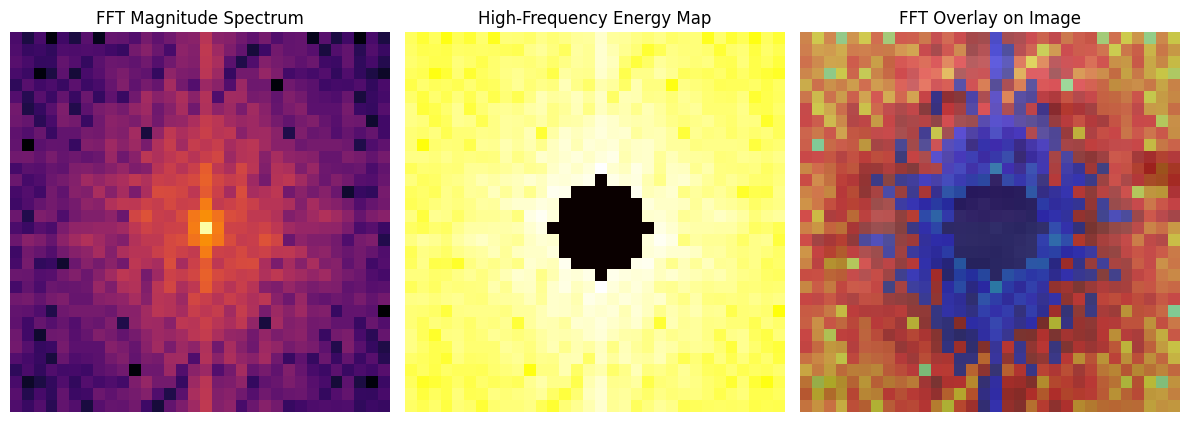

In [ ]:
magnitude, hf_map, overlay = fft_xai(img)
show_fft_xai(img, magnitude, hf_map, overlay)


In [ ]:
import numpy as np
import cv2

def fft_cam_fusion(img_pil, cam_map, high_freq_ratio=0.15, alpha=0.5):
    """
    img_pil: input PIL image
    cam_map: normalized CAM map from Grad-CAM, Score-CAM, etc. shape [H,W]
    high_freq_ratio: how much high-frequency content to keep (0.1 - 0.25 works best)
    alpha: overlay transparency

    returns:
        fused_map: fused CAM + FFT high frequency map
        overlay: visualization overlay on original image
        hf_map: raw high-frequency map
    """
    img = np.array(img_pil).astype(np.float32) / 255.0

    # -----------------------------
    # Step 1: FFT of grayscale image
    # -----------------------------
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)

    h, w = gray.shape
    cy, cx = h // 2, w // 2
    r = int(min(h, w) * high_freq_ratio)

    # Mask out low-frequency center
    mask = np.ones((h, w), np.uint8)
    cv2.circle(mask, (cx, cy), r, 0, -1)

    # High frequency energy
    hf = np.abs(fshift) * mask
    hf = np.log(hf + 1e-8)

    # Normalize HF
    hf_norm = (hf - hf.min()) / (hf.max() + 1e-8)

    # Resize CAM to match FFT
    cam_resized = cv2.resize(cam_map, (w, h))

    # -----------------------------
    # Step 2: Fusion = CAM * HF
    # -----------------------------
    fused = cam_resized * hf_norm
    fused = fused - fused.min()
    fused = fused / (fused.max() + 1e-8)

    # -----------------------------
    # Step 3: Create overlay
    # -----------------------------
    fused_color = cv2.applyColorMap(np.uint8(255 * fused), cv2.COLORMAP_JET)
    fused_color = fused_color[..., ::-1] / 255.0  # BGR->RGB

    overlay = np.clip((1 - alpha) * img + alpha * fused_color, 0, 1)

    return fused, overlay, hf_norm


In [ ]:
import matplotlib.pyplot as plt

def show_fft_cam_fusion(img_pil, fused, overlay, hf_map):
    plt.figure(figsize=(12, 8))

    plt.subplot(2,2,1)
    plt.imshow(img_pil)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2,2,2)
    plt.imshow(hf_map, cmap="hot")
    plt.title("High-Frequency Map (FFT)")
    plt.axis("off")

    plt.subplot(2,2,3)
    plt.imshow(fused, cmap="jet")
    plt.title("CAM ∩ FFT Fusion Map")
    plt.axis("off")

    plt.subplot(2,2,4)
    plt.imshow(overlay)
    plt.title("Overlay Fusion on Original")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


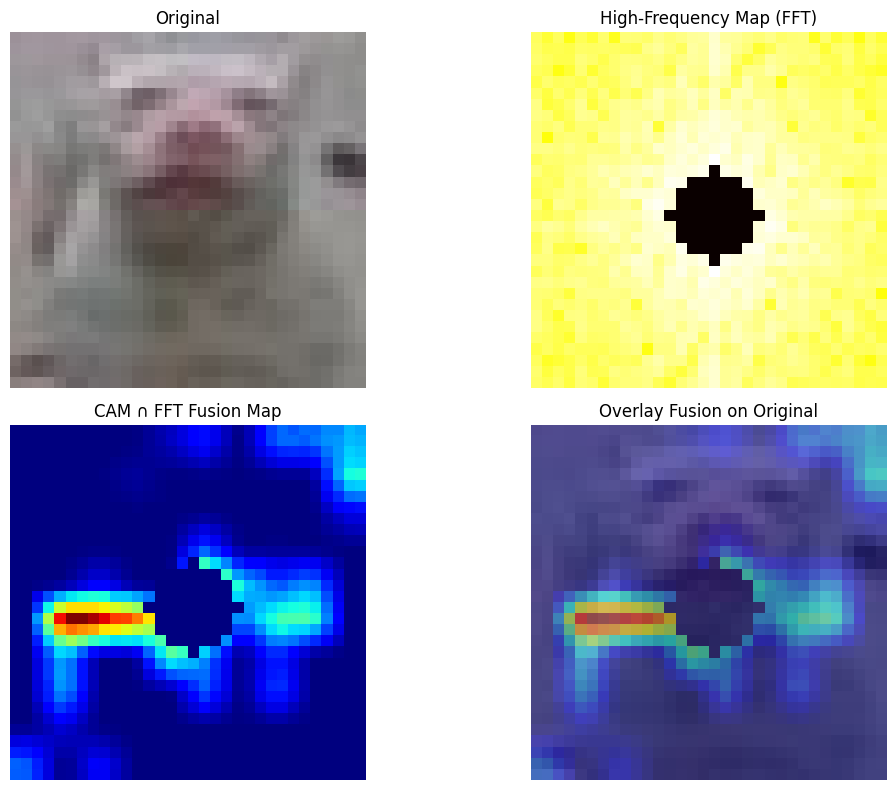

In [ ]:
# Your existing CAM maps
gc_map, _ = gradcam.generate(input_tensor)
gpp_map, _ = gradcam.generate(input_tensor, use_gradcam_plus=True)
sc_map, _ = scorecam.generate(input_tensor)

# Choose the CAM you want to fuse (typically Grad-CAM++)
cam_map = gpp_map  # or sc_map, gc_map

# Run fusion
fused, overlay, hf_map = fft_cam_fusion(img, cam_map)

# Visualize
show_fft_cam_fusion(img, fused, overlay, hf_map)


In [ ]:
import cv2
import numpy as np

def compute_fft_map(img):
    # Convert to grayscale to focus on frequency artifacts
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.float32) / 255.0

    # FFT
    fft = np.fft.fft2(gray)
    fft_shift = np.fft.fftshift(fft)

    # Magnitude Spectrum (raw frequencies)
    magnitude = np.abs(fft_shift)

    # Log scaling (critical – GAN artifacts become visible)
    magnitude_log = np.log1p(magnitude)

    # Normalize to 0–1
    magnitude_norm = (magnitude_log - magnitude_log.min()) / (magnitude_log.max() - magnitude_log.min())

    return magnitude_norm


In [ ]:
def radial_profile(data):
    y, x = np.indices((data.shape))
    center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x-center[0], y-center[1])
    r = r.astype(np.int32)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())

    radialprofile = tbin / (nr + 1e-8)
    return radialprofile


In [ ]:
def compute_gan_fingerprint_map(fft_map, low_cut=15):
    h, w = fft_map.shape
    mask = np.ones((h, w), np.float32)

    # Remove low frequencies (where real images dominate)
    cy, cx = h // 2, w // 2
    cv2.circle(mask, (cx, cy), low_cut, 0, -1)

    fingerprint = fft_map * mask

    # Normalize
    fingerprint = (fingerprint - fingerprint.min()) / (fingerprint.max() - fingerprint.min() + 1e-8)
    return fingerprint


In [ ]:
import matplotlib.pyplot as plt

def compare_real_fake(real_img, fake_img):
    real_fft = compute_fft_map(real_img)
    fake_fft = compute_fft_map(fake_img)

    real_f = compute_gan_fingerprint_map(real_fft)
    fake_f = compute_gan_fingerprint_map(fake_fft)

    plt.figure(figsize=(12,6))
    plt.subplot(2,2,1); plt.title("Real FFT"); plt.imshow(real_fft, cmap='inferno')
    plt.subplot(2,2,2); plt.title("Fake FFT"); plt.imshow(fake_fft, cmap='inferno')
    plt.subplot(2,2,3); plt.title("Real GAN Fingerprint"); plt.imshow(real_f, cmap='jet')
    plt.subplot(2,2,4); plt.title("Fake GAN Fingerprint"); plt.imshow(fake_f, cmap='jet')
    plt.show()

    # Radial comparison
    rp_real = radial_profile(real_fft)
    rp_fake = radial_profile(fake_fft)

    plt.figure(figsize=(10,4))
    plt.plot(rp_real, label="Real")
    plt.plot(rp_fake, label="Fake")
    plt.title("Radial Frequency Profile")
    plt.legend()
    plt.show()


In [ ]:
def fuse_cam_fft(cam_map, fft_map):
    # Resize CAM to match FFT
    cam_resized = cv2.resize(cam_map, (fft_map.shape[1], fft_map.shape[0]))

    cam_norm = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)
    fft_norm = (fft_map - fft_map.min()) / (fft_map.max() - fft_map.min() + 1e-8)

    fusion = cam_norm * (fft_norm ** 1.5)
    fusion = fusion / (fusion.max() + 1e-8)
    return fusion


In [ ]:
import zipfile
from PIL import Image
import io
import random

def load_random_image(zip_path):
    with zipfile.ZipFile(zip_path, "r") as z:
        names = [n for n in z.namelist() if n.lower().endswith(("png","jpg","jpeg"))]
        img_name = random.choice(names)
        img = Image.open(io.BytesIO(z.read(img_name))).convert("RGB")
        return img, img_name


In [ ]:
fake_img, fake_name = load_random_image(ZIP_FAKE)
real_img, real_name = load_random_image(ZIP_REAL)

print("Loaded REAL image:", real_name)
print("Loaded FAKE image:", fake_name)


Loaded REAL image: real_cifake_images/817.png
Loaded FAKE image: fake_cifake_images/101.png


In [ ]:
real_np = cv2.cvtColor(np.array(real_img), cv2.COLOR_RGB2BGR)
fake_np = cv2.cvtColor(np.array(fake_img), cv2.COLOR_RGB2BGR)


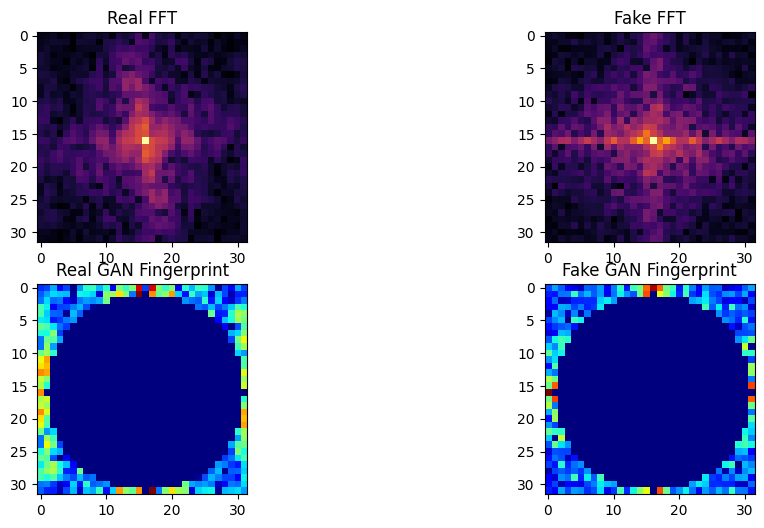

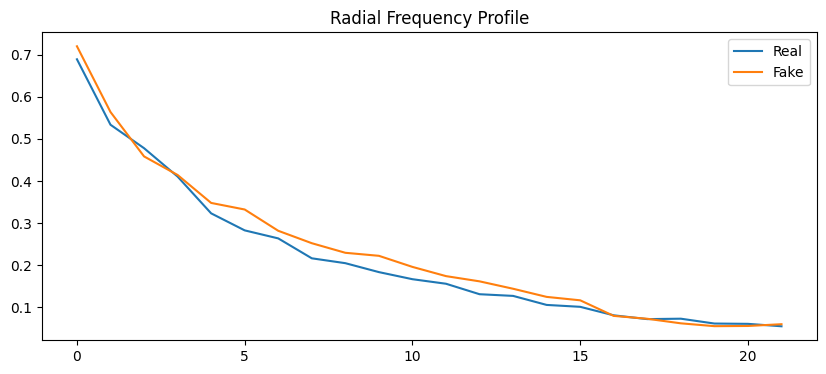

In [ ]:
compare_real_fake(real_np, fake_np)


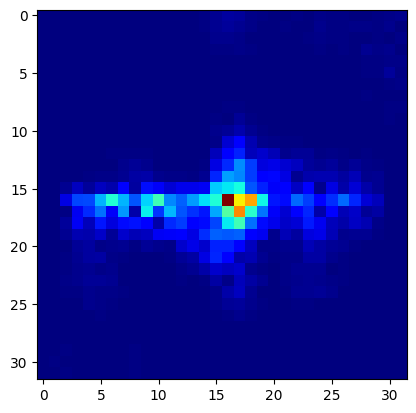

In [ ]:


# Proceed with fusion
fusion = fuse_cam_fft(cam_map, fft_map)
plt.imshow(fusion, cmap='jet')
plt.show()


In [ ]:
cam_map, _ = gradcam.generate(input_tensor, use_gradcam_plus=True)


In [ ]:
print(type(fake_img))


<class 'PIL.Image.Image'>


In [ ]:
# ============================================================
# FINE-TUNE AND COMPARE MODELS ON YOUR CIFAKE DATASET
# ResNet-50 vs EfficientNet-Lite0 (both fair, identical training)
# ============================================================

import os
import io
import time
import zipfile
import numpy as np
from PIL import Image
from collections import defaultdict

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

from sklearn.metrics import precision_score, recall_score, f1_score
from timm import create_model

# ============================================================
# CONFIGURATION
# ============================================================
ZIP_FAKE = "/content/zip_fake_cifake_images.zip"
ZIP_REAL = "/content/zip_real_cifake_images.zip"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGE_SIZE = 320
BATCH_SIZE = 12
EPOCHS = 30
PATIENCE = 8

LR_MAX = 5e-5
WEIGHT_DECAY = 1e-4
DROPOUT = 0.3
LABEL_SMOOTHING = 0.1

LABEL_MAP = {"fake": 0, "real": 1}
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

# ============================================================
# YOUR ORIGINAL DATASET CLASS (kept EXACT same)
# ============================================================
class ZipImageDataset(Dataset):
    def __init__(self, zip_path, label_name, transforms=None):
        self.zip_path = zip_path
        self.label = LABEL_MAP[label_name]
        self.transforms = transforms
        self.images = []

        with zipfile.ZipFile(zip_path, "r") as z:
            for name in z.namelist():
                if name.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.images.append(name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        with zipfile.ZipFile(self.zip_path, "r") as z:
            img = Image.open(io.BytesIO(z.read(self.images[idx]))).convert("RGB")

        if self.transforms:
            img = self.transforms(img)
        else:
            img = T.ToTensor()(img)

        return img, torch.tensor(self.label)


# ============================================================
# TTA VALIDATION (your code, unchanged)
# ============================================================
def validate_tta(model, loader):
    model.eval()
    preds, labs = [], []
    softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            outputs = []
            for f in [None, [3], [2], [2, 3]]:
                xa = torch.flip(x, f) if f else x
                outputs.append(softmax(model(xa)))

            out = torch.mean(torch.stack(outputs), dim=0)

            preds += out.argmax(1).cpu().tolist()
            labs += y.cpu().tolist()

    preds, labs = np.array(preds), np.array(labs)
    acc = (preds == labs).mean() * 100
    p = precision_score(labs, preds, zero_division=0)
    r = recall_score(labs, preds, zero_division=0)
    f = f1_score(labs, preds, zero_division=0)

    return acc, p, r, f


# ============================================================
# MODEL BUILDER (for both backbones)
# ============================================================
def build_model(arch):
    model = create_model(
        arch,
        pretrained=True,
        num_classes=2,
        drop_rate=DROPOUT
    )
    return model.to(DEVICE)


# ============================================================
# UNIVERSAL TRAINING LOOP (same as ConvNeXt)
# ============================================================
def train_any_model(model, train_loader, val_loader, arch_name):
    print(f"\n=========== TRAINING {arch_name} ===========")

    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

    optimizer = optim.AdamW(model.parameters(), lr=LR_MAX, weight_decay=WEIGHT_DECAY)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=1e-7
    )

    best_acc = 0
    wait = 0
    scaler = torch.cuda.amp.GradScaler()

    for ep in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                out = model(imgs)
                loss = criterion(out, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            running_loss += loss.item() * imgs.size(0)

        avg_loss = running_loss / len(train_loader.dataset)

        acc, p, r, f = validate_tta(model, val_loader)
        print(f"[{arch_name}] Epoch {ep}/{EPOCHS} | Loss={avg_loss:.4f} | Acc={acc:.2f}% | F1={f:.3f}")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), f"best_{arch_name}.pth")
            wait = 0
        else:
            wait += 1
            if wait >= PATIENCE:
                print(f"Early stopping for {arch_name}")
                break

    print(f">>> Best Accuracy for {arch_name}: {best_acc:.2f}%")
    return best_acc


# ============================================================
# MAIN COMPARISON FUNCTION
# ============================================================
def compare_resnet_effnet():

    print("\n======== LOADING DATASET ========")

    train_tf = T.Compose([
        T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        T.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(15),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_tf = T.Compose([
        T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    fake_ds = ZipImageDataset(ZIP_FAKE, "fake")
    real_ds = ZipImageDataset(ZIP_REAL, "real")

    full_ds = torch.utils.data.ConcatDataset([fake_ds, real_ds])
    n = len(full_ds)
    val_size = int(0.15 * n)

    train_ds, val_ds = random_split(
        full_ds,
        [n - val_size, val_size],
        generator=torch.Generator().manual_seed(SEED)
    )

    train_ds.dataset.transforms = train_tf
    val_ds.dataset.transforms = val_tf

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE*2, shuffle=False)

    # ------------------------------
    # 1: Build models
    # ------------------------------
    resnet = build_model("resnet50")
    effnet = build_model("efficientnet_lite0")

    # ------------------------------
    # 2: Train both
    # ------------------------------
    train_any_model(resnet, train_loader, val_loader, "resnet50")
    train_any_model(effnet,  train_loader, val_loader, "efficientnet_lite0")

    # ------------------------------
    # 3: Load best weights + evaluate
    # ------------------------------
    resnet.load_state_dict(torch.load("best_resnet50.pth", map_location=DEVICE))
    effnet.load_state_dict(torch.load("best_efficientnet_lite0.pth", map_location=DEVICE))

    r_acc, r_p, r_r, r_f = validate_tta(resnet, val_loader)
    e_acc, e_p, e_r, e_f = validate_tta(effnet, val_loader)

    print("\n========= FINAL COMPARISON =========")
    print("Model\t\tAcc\tF1\tPrec\tRecall")
    print(f"ResNet50\t{r_acc:.2f}\t{r_f:.3f}\t{r_p:.3f}\t{r_r:.3f}")
    print(f"EffNet-Lite0\t{e_acc:.2f}\t{e_f:.3f}\t{e_p:.3f}\t{e_r:.3f}")
    print("====================================")

    return {
        "ResNet50": {"acc": r_acc, "f1": r_f, "p": r_p, "r": r_r},
        "EffNetLite0": {"acc": e_acc, "f1": e_f, "p": e_p, "r": e_r},
    }


# ============================================================
# RUN THE FULL COMPARISON
# ============================================================
compare_resnet_effnet()



======== LOADING DATASET ========


model.safetensors:   0%|          | 0.00/18.8M [00:00<?, ?B/s]


=========== TRAINING resnet50 ===========


/tmp/ipython-input-1209289870.py:136: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 1/30 | Loss=0.6944 | Acc=50.33% | F1=0.425


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 2/30 | Loss=0.6925 | Acc=54.33% | F1=0.516


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 3/30 | Loss=0.6922 | Acc=54.67% | F1=0.460


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 4/30 | Loss=0.6870 | Acc=56.67% | F1=0.492


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 5/30 | Loss=0.6833 | Acc=60.00% | F1=0.496


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 6/30 | Loss=0.6799 | Acc=60.67% | F1=0.596


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 7/30 | Loss=0.6751 | Acc=65.00% | F1=0.649


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 8/30 | Loss=0.6792 | Acc=63.33% | F1=0.574


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 9/30 | Loss=0.6708 | Acc=65.67% | F1=0.641


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 10/30 | Loss=0.6695 | Acc=65.67% | F1=0.620


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 11/30 | Loss=0.6696 | Acc=69.00% | F1=0.680


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 12/30 | Loss=0.6575 | Acc=69.67% | F1=0.687


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 13/30 | Loss=0.6525 | Acc=75.33% | F1=0.728


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 14/30 | Loss=0.6468 | Acc=72.67% | F1=0.717


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 15/30 | Loss=0.6489 | Acc=72.67% | F1=0.705


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 16/30 | Loss=0.6482 | Acc=73.00% | F1=0.724


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 17/30 | Loss=0.6451 | Acc=71.00% | F1=0.693


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 18/30 | Loss=0.6472 | Acc=72.00% | F1=0.702


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 19/30 | Loss=0.6345 | Acc=73.67% | F1=0.725


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 20/30 | Loss=0.6320 | Acc=74.33% | F1=0.716


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[resnet50] Epoch 21/30 | Loss=0.6283 | Acc=73.00% | F1=0.729
Early stopping for resnet50
>>> Best Accuracy for resnet50: 75.33%

=========== TRAINING efficientnet_lite0 ===========


/tmp/ipython-input-1209289870.py:136: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 1/30 | Loss=5.4705 | Acc=56.00% | F1=0.563


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 2/30 | Loss=4.9118 | Acc=58.00% | F1=0.601


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 3/30 | Loss=4.9895 | Acc=61.00% | F1=0.589


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 4/30 | Loss=4.3309 | Acc=61.67% | F1=0.588


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 5/30 | Loss=4.5532 | Acc=64.67% | F1=0.649


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 6/30 | Loss=4.0278 | Acc=73.00% | F1=0.725


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 7/30 | Loss=3.8599 | Acc=71.33% | F1=0.684


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 8/30 | Loss=3.7558 | Acc=73.33% | F1=0.724


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 9/30 | Loss=3.7814 | Acc=70.67% | F1=0.697


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 10/30 | Loss=3.7930 | Acc=68.67% | F1=0.669


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 11/30 | Loss=3.2914 | Acc=70.33% | F1=0.702


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 12/30 | Loss=3.1272 | Acc=74.00% | F1=0.738


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 13/30 | Loss=3.1450 | Acc=70.67% | F1=0.694


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 14/30 | Loss=3.0480 | Acc=71.67% | F1=0.691


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 15/30 | Loss=2.8634 | Acc=71.00% | F1=0.677


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 16/30 | Loss=2.9803 | Acc=70.00% | F1=0.648


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 17/30 | Loss=3.2498 | Acc=73.00% | F1=0.699


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 18/30 | Loss=3.1268 | Acc=69.67% | F1=0.654


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 19/30 | Loss=2.8014 | Acc=73.33% | F1=0.701


/tmp/ipython-input-1209289870.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[efficientnet_lite0] Epoch 20/30 | Loss=2.5870 | Acc=73.33% | F1=0.704
Early stopping for efficientnet_lite0
>>> Best Accuracy for efficientnet_lite0: 74.00%

========= FINAL COMPARISON =========
Model		Acc	F1	Prec	Recall
ResNet50	75.33	0.728	0.780	0.683
EffNet-Lite0	74.00	0.738	0.719	0.759


{'ResNet50': {'acc': np.float64(75.33333333333333),
  'f1': 0.7279411764705882,
  'p': 0.7795275590551181,
  'r': 0.6827586206896552},
 'EffNetLite0': {'acc': np.float64(74.0),
  'f1': 0.738255033557047,
  'p': 0.7189542483660131,
  'r': 0.7586206896551724}}